In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

# MNIST 데이터를 다운로드 합니다.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# 이미지들을 float32 데이터 타입으로 변경합니다.
x_train, x_test = x_train.astype('float32'), x_test.astype('float32')
# 28*28 형태의 이미지를 784차원으로 flattening 합니다.
x_train, x_test = x_train.reshape([-1, 784]), x_test.reshape([-1, 784])
# [0, 255] 사이의 값을 [0, 1]사이의 값으로 Normalize합니다.
x_train, x_test = x_train / 255., x_test / 255.


In [3]:
# 생성된 MNIST 이미지를 8x8 Grid로 보여주는 plot 함수를 정의합니다.
def plot(samples):
  fig = plt.figure(figsize=(8, 8))
  gs = gridspec.GridSpec(8, 8)
  gs.update(wspace=0.05, hspace=0.05)

  for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    plt.imshow(sample.reshape(28, 28))

  return fig

In [4]:
num_epoch = 100000
batch_size = 64
num_input = 28 * 28
num_latent_variable = 100   # 잠재 변수 z의 차원
num_hidden = 128
learning_rate = 0.001

# tf.data API를 이용해서 데이터를 섞고 batch 형태로 가져옵니다.
train_data = tf.data.Dataset.from_tensor_slices(x_train)
train_data = train_data.repeat().shuffle(60000).batch(batch_size)
train_data_iter = iter(train_data)

In [7]:
class Generator(object):
  # Generator 모델을 위한 tf.Variable들을 정의합니다.
  def __init__(self):
    # 100 -> 128 -> 784
    # 히든 레이어 파라미터
    self.G_W1 = tf.Variable(tf.random.normal(shape=[num_latent_variable, num_hidden], stddev=5e-2))
    self.G_b1 = tf.Variable(tf.constant(0.1, shape=[num_hidden]))
    # 아웃풋 레이어 파라미터
    self.G_W2 = tf.Variable(tf.random.normal(shape=[num_hidden, num_input], stddev=5e-2))
    self.G_b2 = tf.Variable(tf.constant(0.1, shape=[num_input]))

  def __call__(self, X):
    hidden_layer = tf.nn.relu((tf.matmul(X, self.G_W1) + self.G_b1))
    output_layer = tf.matmul(hidden_layer, self.G_W2) + self.G_b2
    generated_mnist_image = tf.nn.sigmoid(output_layer)

    return generated_mnist_image


In [8]:
# nn 을 사용한 Discriminator
class Discriminator(object):
  # Discriminator 모델을 위한 tf.Variable들을 정의합니다.
  def __init__(self):
    # 784 -> 128 -> 1
    # 히든 레이어 파라미터
    self.D_W1 = tf.Variable(tf.random.normal(shape=[num_input, num_hidden], stddev=5e-2))
    self.D_b1 = tf.Variable(tf.constant(0.1, shape=[num_hidden]))
    # 아웃풋 레이어 파라미터
    self.D_W2 = tf.Variable(tf.random.normal(shape=[num_hidden, 1], stddev=5e-2)) # 0 or 1 : 진짜인지 아닌지.
    self.D_b2 = tf.Variable(tf.constant(0.1, shape=[1]))

  def __call__(self, X):
    hidden_layer = tf.nn.relu((tf.matmul(X, self.D_W1) + self.D_b1))
    logits = tf.matmul(hidden_layer, self.D_W2) + self.D_b2
    predicted_value = tf.nn.sigmoid(logits)

    return predicted_value, logits


In [10]:
# Generator의 손실 함수를 정의합니다. : Generator는 logit이 모두 1이 되는 것을 목표로 한다.
@tf.function
def generator_loss(D_fake_logits):
  return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones_like(D_fake_logits)))         # log(D(G(z))

# Discriminator의 손실 함수를 정의합니다.
@tf.function
def discriminator_loss(D_real_logits, D_fake_logits):
  d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones_like(D_real_logits)))  # log(D(x))
  d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros_like(D_fake_logits)))  # log(1-D(G(z)))
  d_loss = d_loss_real + d_loss_fake  # log(D(x)) + log(1-D(G(z)))

  return d_loss

In [11]:
# 생성자(Generator) 모델을 선언합니다.
Generator_model = Generator()

# 구분자(Discriminator) 모델을 선언합니다.
Discriminator_model = Discriminator()

# Discriminator와 Generator를 위한 Optimizer들을 정의합니다.
discriminator_optimizer = tf.optimizers.Adam(learning_rate)
generator_optimizer = tf.optimizers.Adam(learning_rate)


In [12]:
# Discriminator 최적화를 위한 function을 정의합니다.
@tf.function
def d_train_step(discriminator_model, real_image, fake_image):
  with tf.GradientTape() as disc_tape:
    D_real, D_real_logits = discriminator_model(real_image)  # D(x)
    D_fake, D_fake_logits = discriminator_model(fake_image)  # D(G(z))
    loss = discriminator_loss(D_real_logits, D_fake_logits)
  gradients = disc_tape.gradient(loss, vars(discriminator_model).values())
  discriminator_optimizer.apply_gradients(zip(gradients, vars(discriminator_model).values()))

# Generator 최적화를 위한 function을 정의합니다.
@tf.function
def g_train_step(generator_model, discriminator_model, z):
  with tf.GradientTape() as gen_tape:
    G = generator_model(z)
    D_fake, D_fake_logits = discriminator_model(G)  # D(G(z))
    loss = generator_loss(D_fake_logits)
  gradients = gen_tape.gradient(loss, vars(generator_model).values())
  generator_optimizer.apply_gradients(zip(gradients, vars(generator_model).values()))


In [13]:
# 생성된 이미지들을 저장할 generated_output 폴더를 생성합니다.
num_img = 0
if not os.path.exists('generated_output/'):
  os.makedirs('generated_output/')

반복(Epoch): 0, Generator 손실함수(g_loss): 1.327222, Discriminator 손실함수(d_loss): 0.966454
반복(Epoch): 100, Generator 손실함수(g_loss): 1.854806, Discriminator 손실함수(d_loss): 0.610936
반복(Epoch): 200, Generator 손실함수(g_loss): 3.188316, Discriminator 손실함수(d_loss): 0.096363
반복(Epoch): 300, Generator 손실함수(g_loss): 4.224580, Discriminator 손실함수(d_loss): 0.024153
반복(Epoch): 400, Generator 손실함수(g_loss): 4.361003, Discriminator 손실함수(d_loss): 0.022681
반복(Epoch): 500, Generator 손실함수(g_loss): 4.526054, Discriminator 손실함수(d_loss): 0.034145
반복(Epoch): 600, Generator 손실함수(g_loss): 5.158538, Discriminator 손실함수(d_loss): 0.011473
반복(Epoch): 700, Generator 손실함수(g_loss): 5.847951, Discriminator 손실함수(d_loss): 0.006504
반복(Epoch): 800, Generator 손실함수(g_loss): 5.119422, Discriminator 손실함수(d_loss): 0.009901
반복(Epoch): 900, Generator 손실함수(g_loss): 6.400676, Discriminator 손실함수(d_loss): 0.008115
반복(Epoch): 1000, Generator 손실함수(g_loss): 8.876619, Discriminator 손실함수(d_loss): 0.008843
반복(Epoch): 1100, Generator 손실함수(g_loss): 7.6

반복(Epoch): 9400, Generator 손실함수(g_loss): 2.598029, Discriminator 손실함수(d_loss): 0.875098
반복(Epoch): 9500, Generator 손실함수(g_loss): 3.291448, Discriminator 손실함수(d_loss): 0.497645
반복(Epoch): 9600, Generator 손실함수(g_loss): 2.842590, Discriminator 손실함수(d_loss): 0.423078
반복(Epoch): 9700, Generator 손실함수(g_loss): 3.214129, Discriminator 손실함수(d_loss): 0.528513
반복(Epoch): 9800, Generator 손실함수(g_loss): 3.371948, Discriminator 손실함수(d_loss): 0.805510
반복(Epoch): 9900, Generator 손실함수(g_loss): 2.837284, Discriminator 손실함수(d_loss): 0.499923
반복(Epoch): 10000, Generator 손실함수(g_loss): 2.648121, Discriminator 손실함수(d_loss): 0.499292
반복(Epoch): 10100, Generator 손실함수(g_loss): 2.766978, Discriminator 손실함수(d_loss): 0.491716
반복(Epoch): 10200, Generator 손실함수(g_loss): 3.335978, Discriminator 손실함수(d_loss): 0.534025
반복(Epoch): 10300, Generator 손실함수(g_loss): 2.375823, Discriminator 손실함수(d_loss): 0.459950
반복(Epoch): 10400, Generator 손실함수(g_loss): 2.019804, Discriminator 손실함수(d_loss): 0.640636
반복(Epoch): 10500, Generator

반복(Epoch): 18700, Generator 손실함수(g_loss): 1.869143, Discriminator 손실함수(d_loss): 0.561306
반복(Epoch): 18800, Generator 손실함수(g_loss): 1.505929, Discriminator 손실함수(d_loss): 0.665762
반복(Epoch): 18900, Generator 손실함수(g_loss): 1.723256, Discriminator 손실함수(d_loss): 0.689753
반복(Epoch): 19000, Generator 손실함수(g_loss): 1.345522, Discriminator 손실함수(d_loss): 0.812339
반복(Epoch): 19100, Generator 손실함수(g_loss): 1.767320, Discriminator 손실함수(d_loss): 0.673541
반복(Epoch): 19200, Generator 손실함수(g_loss): 2.335227, Discriminator 손실함수(d_loss): 0.610187
반복(Epoch): 19300, Generator 손실함수(g_loss): 1.990065, Discriminator 손실함수(d_loss): 0.684827
반복(Epoch): 19400, Generator 손실함수(g_loss): 1.885419, Discriminator 손실함수(d_loss): 0.875513
반복(Epoch): 19500, Generator 손실함수(g_loss): 1.546583, Discriminator 손실함수(d_loss): 1.007462
반복(Epoch): 19600, Generator 손실함수(g_loss): 2.045601, Discriminator 손실함수(d_loss): 0.818565
반복(Epoch): 19700, Generator 손실함수(g_loss): 2.000937, Discriminator 손실함수(d_loss): 0.568875
반복(Epoch): 19800, Gen

반복(Epoch): 28000, Generator 손실함수(g_loss): 2.089205, Discriminator 손실함수(d_loss): 0.731951
반복(Epoch): 28100, Generator 손실함수(g_loss): 2.102567, Discriminator 손실함수(d_loss): 0.703692
반복(Epoch): 28200, Generator 손실함수(g_loss): 1.474073, Discriminator 손실함수(d_loss): 0.852748
반복(Epoch): 28300, Generator 손실함수(g_loss): 1.806680, Discriminator 손실함수(d_loss): 0.750356
반복(Epoch): 28400, Generator 손실함수(g_loss): 2.023530, Discriminator 손실함수(d_loss): 0.710907
반복(Epoch): 28500, Generator 손실함수(g_loss): 1.957280, Discriminator 손실함수(d_loss): 0.733091
반복(Epoch): 28600, Generator 손실함수(g_loss): 1.790385, Discriminator 손실함수(d_loss): 0.718479
반복(Epoch): 28700, Generator 손실함수(g_loss): 1.963101, Discriminator 손실함수(d_loss): 0.770121
반복(Epoch): 28800, Generator 손실함수(g_loss): 1.827531, Discriminator 손실함수(d_loss): 0.539641
반복(Epoch): 28900, Generator 손실함수(g_loss): 1.748639, Discriminator 손실함수(d_loss): 0.644236
반복(Epoch): 29000, Generator 손실함수(g_loss): 2.093054, Discriminator 손실함수(d_loss): 0.881483
반복(Epoch): 29100, Gen

KeyboardInterrupt: 

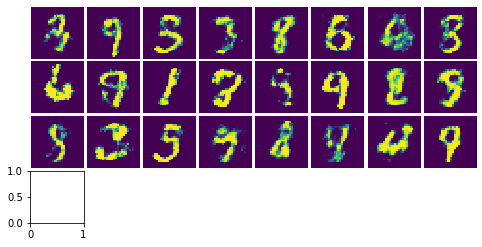

In [14]:
for i in range(num_epoch):
  # MNIST 이미지를 batch_size만큼 불러옵니다.
  batch_X = next(train_data_iter)

  # Latent Variable의 인풋으로 사용할 noise를 Uniform Distribution에서 batch_size 개수만큼 샘플링합니다.
  batch_noise = np.random.uniform(-1., 1., [batch_size, 100]).astype('float32')

  # 500번 반복할때마다 생성된 이미지를 저장합니다.
  if i % 500 == 0:
    samples = Generator_model(np.random.uniform(-1., 1., [64, 100]).astype('float32')).numpy()
    fig = plot(samples)
    plt.savefig('generated_output/%s.png' % str(num_img).zfill(3), bbox_inches='tight')
    num_img += 1
    plt.close(fig)

  # Discriminator 최적화를 수행하고 Discriminator의 손실함수를 return합니다.
  _, d_loss_print = d_train_step(Discriminator_model, batch_X, Generator_model(batch_noise)), discriminator_loss(Discriminator_model(batch_X)[1], Discriminator_model(Generator_model(batch_noise))[1])

  # Generator 최적화를 수행하고 Generator 손실함수를 return합니다.
  _, g_loss_print = g_train_step(Generator_model, Discriminator_model, batch_noise), generator_loss(Discriminator_model(Generator_model(batch_noise))[1])

  # 100번 반복할때마다 Discriminator의 손실함수와 Generator 손실함수를 출력합니다.
  if i % 100 == 0:
    print('반복(Epoch): %d, Generator 손실함수(g_loss): %f, Discriminator 손실함수(d_loss): %f' % (i, g_loss_print, d_loss_print))


In [ ]:
#어떤 숫자가 가장 잘 만들어질까?